In [2]:
import subprocess
import sys

# Asegurar la instalación de pandas
try:
    import pandas as pd
except ImportError:
    print("pandas is not installed. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pandas", "--user"])
    import pandas as pd

# Asegurar la instalación de matplotlib
try:
    import matplotlib.pyplot as plt
except ImportError:
    print("matplotlib is not installed. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "matplotlib", "--user"])
    import matplotlib.pyplot as plt

# Asegurar la instalación de ydata-profiling
try:
    from ydata_profiling import ProfileReport
except ImportError:
    print("ydata-profiling is not installed. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ydata-profiling", "--user"])
    from ydata_profiling import ProfileReport


import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, roc_auc_score, roc_curve
from sklearn import tree
from sklearn.preprocessing import LabelBinarizer    
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline


c:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
import pandas
dataset_path = os.path.join('data', 'used_cars_data.csv')

df=pd.read_csv(dataset_path)
df = pd.DataFrame(df)

In [4]:
df['Power'] = df['Power'].apply(lambda x: str(x)[:-3] if isinstance(x, str) and len(x) >= 3 else x)

In [5]:
df['Engine'] = df['Engine'].apply(lambda x: str(x)[:-2] if isinstance(x, str) and len(x) >= 2 else x)

In [6]:
df['Mileage'] = df['Mileage'].str.replace(r'[^0-9.]', '', regex=True).astype(float)

# Ver los primeros valores de Mileage después de limpiar
print("\nValores de Mileage después de limpiar:")
print(df['Mileage'].head())

# Verificar si hay valores NaN después de la conversión
missing_mileage = df['Mileage'].isna().sum()
print(f"\nNúmero de valores faltantes en Mileage después de la limpieza: {missing_mileage}")


Valores de Mileage después de limpiar:
0    26.60
1    19.67
2    18.20
3    20.77
4    15.20
Name: Mileage, dtype: float64

Número de valores faltantes en Mileage después de la limpieza: 2


In [7]:
df.head(5)

,S.No.,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998,58.16,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582,126.2,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199,88.7,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248,88.76,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968,140.8,5.0,NaN,17.74


Precision: 0.92


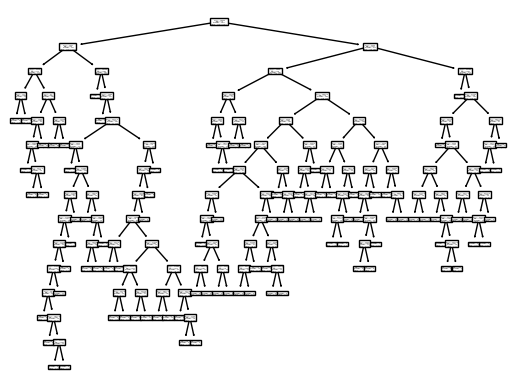

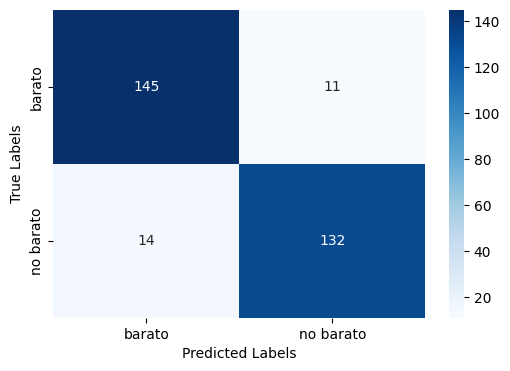

ROC AUC: 0.98


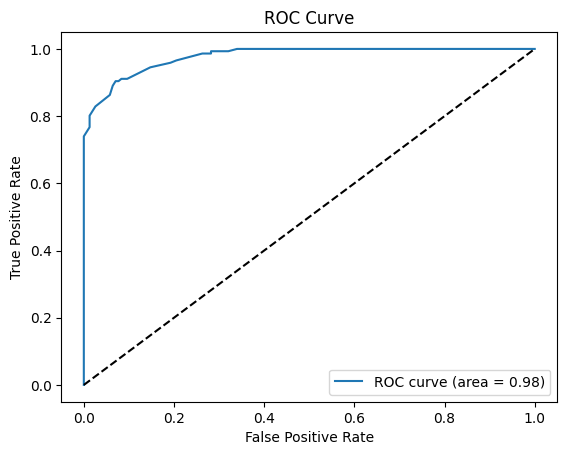

Year: 0.0501
Kilometers_Driven: 0.1218
Seats: 0.0094
Mileage: 0.8187


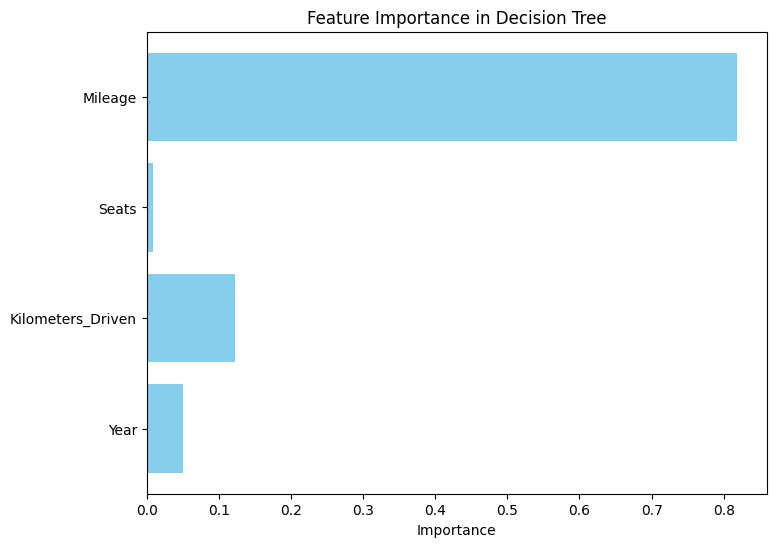

In [8]:
numeric_features = ['Year', 'Kilometers_Driven', 'Seats']
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].mean())

df['Mileage'] = df['Mileage'].astype(str)
df['Mileage'] = df['Mileage'].replace('', np.nan)
df['Mileage'] = df['Mileage'].str.replace(r'[^0-9.]', '', regex=True)
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')
df['Mileage'] = df['Mileage'].fillna(df['Mileage'].mean())

df['New_Price'] = df['New_Price'].astype(str).str.replace(r'[^0-9.]', '', regex=True)
df['New_Price'] = pd.to_numeric(df['New_Price'], errors='coerce')
df = df.dropna(subset=['New_Price'])
median_price = df['New_Price'].median()

df['New_Price_Category'] = np.where(df['New_Price'] <= median_price, 'barato', 'no barato')

X = df[numeric_features + ['Mileage']]
y = df['New_Price_Category']
clf = tree.DecisionTreeClassifier(min_samples_leaf = 5, min_samples_split = 5)  
clf = clf.fit(X, y)
tree.plot_tree(clf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_pred = clf.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.2f}')

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test).ravel()

# ROC AUC (Binary or One-vs-Rest for multiclass)
if len(clf.classes_) == 2:  # Binary classification
    y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f'ROC AUC: {auc:.2f}')
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()
else:  # Multiclass classification
    y_pred_proba = clf.predict_proba(X_test)  # Get probability for all classes
    y_test_bin = pd.get_dummies(y_test)  # One-hot encode the true labels
    auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='weighted')  # One-vs-Rest (OvR)
    print(f'Multiclass ROC AUC: {auc:.2f}')

feature_importances = clf.feature_importances_
for feature, importance in zip(X.columns, feature_importances):
        print(f'{feature}: {importance:.4f}')

plt.figure(figsize=(8, 6))
plt.barh(X.columns, feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Decision Tree')
plt.show()

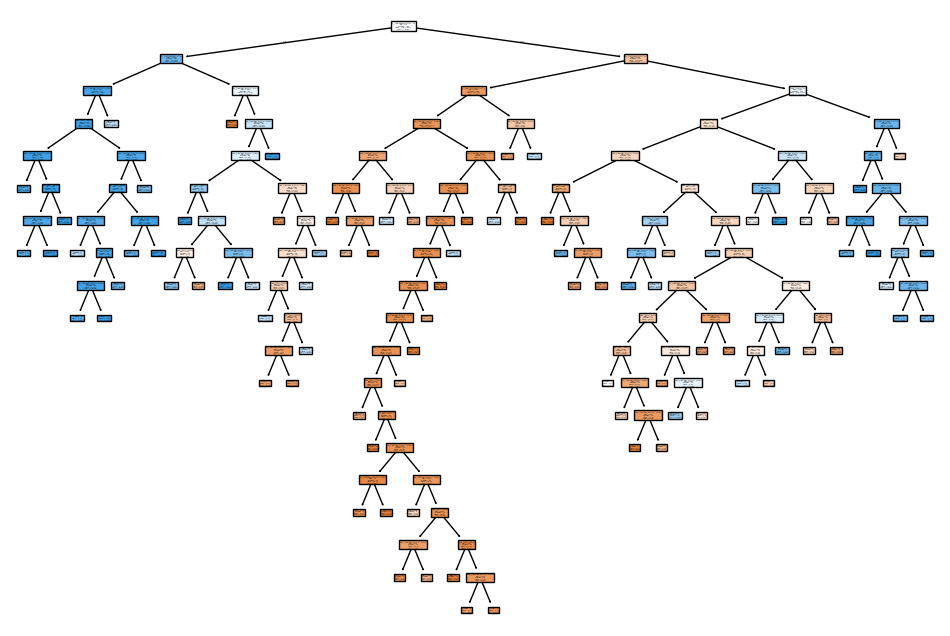

Precision: 0.71


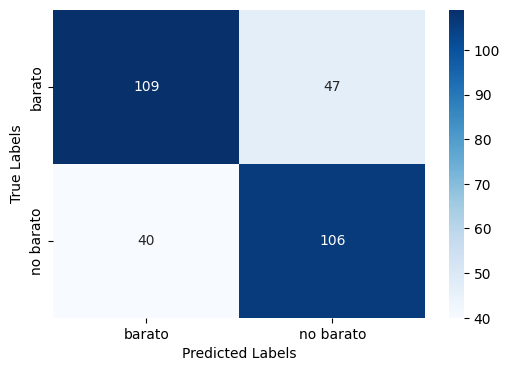

ROC AUC: 0.76


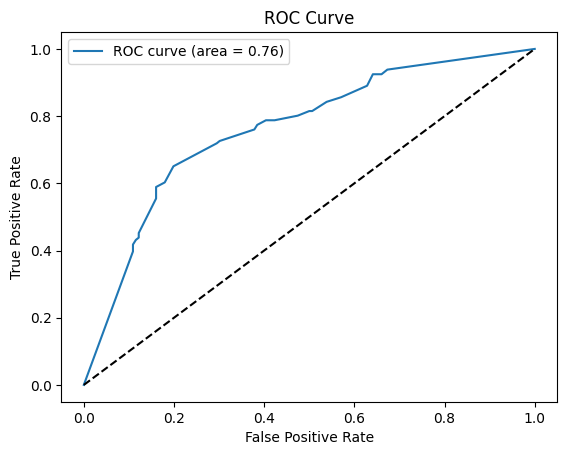

num__Year: 0.0927
num__Kilometers_Driven: 0.2277
num__Seats: 0.0570
cat__Fuel_Type_Diesel: 0.1560
cat__Fuel_Type_Electric: 0.0000
cat__Fuel_Type_Petrol: 0.0989
cat__Owner_Type_Second: 0.0195
cat__Owner_Type_Third: 0.0000
cat__Transmission_Manual: 0.3482


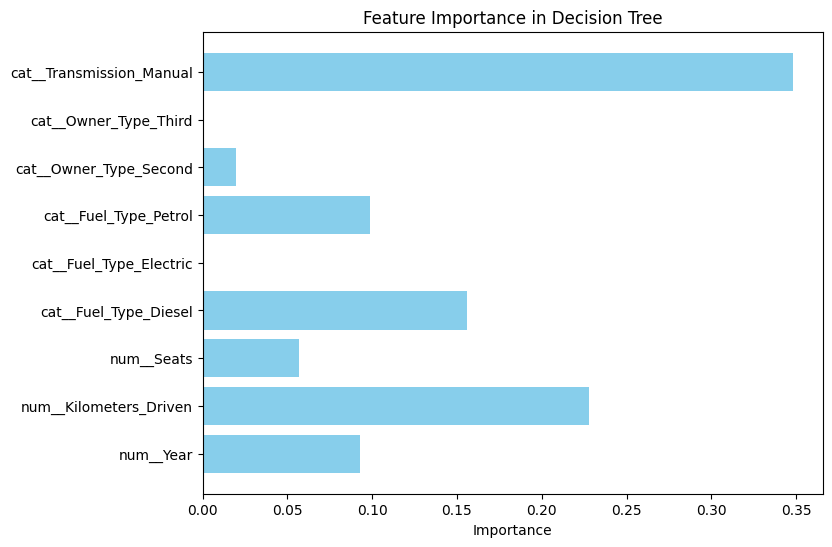

In [11]:
numeric_features = ['Year', 'Kilometers_Driven', 'Seats']
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].mean())

# Clean 'Mileage' column
df['Mileage'] = df['Mileage'].astype(str)
df['Mileage'] = df['Mileage'].replace('', np.nan)
df['Mileage'] = df['Mileage'].str.replace(r'[^0-9.]', '', regex=True)
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')
df['Mileage'] = df['Mileage'].fillna(df['Mileage'].mean())

# Clean 'New_Price' column and categorize
df['New_Price'] = df['New_Price'].astype(str).str.replace(r'[^0-9.]', '', regex=True)
df['New_Price'] = pd.to_numeric(df['New_Price'], errors='coerce')
df = df.dropna(subset=['New_Price'])
median_price = df['New_Price'].median()
df['New_Price_Category'] = np.where(df['New_Price'] <= median_price, 'barato', 'no barato')

# Categorical features
categorical_features = ["Fuel_Type", "Owner_Type", "Transmission"]

# Preprocessing pipeline: numeric and categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),  # Pass through numeric columns unchanged
        ('cat', encoder, categorical_features)  # One-hot encode categorical columns
    ])

# Decision tree classifier pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=5))
])

# Features and target variable
X = df[numeric_features + categorical_features + ['Mileage']]
y = df['New_Price_Category']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline
clf = clf.fit(X_train, y_train)

# Get the fitted decision tree
fitted_tree = clf.named_steps['classifier']

# Plot the decision tree
plt.figure(figsize=(12, 8))
tree.plot_tree(fitted_tree, feature_names=clf.named_steps['preprocessor'].get_feature_names_out(), class_names=fitted_tree.classes_, filled=True)
plt.show()

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate precision score
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.2f}')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# ROC AUC (Binary or One-vs-Rest for multiclass)
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test).ravel()

if len(clf.classes_) == 2:  # Binary classification
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f'ROC AUC: {auc:.2f}')
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()
else:  # Multiclass classification
    y_pred_proba = clf.predict_proba(X_test)
    y_test_bin = pd.get_dummies(y_test)
    auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='weighted')
    print(f'Multiclass ROC AUC: {auc:.2f}')

# Access feature importances from the decision tree
feature_importances = fitted_tree.feature_importances_

# Get the full feature names (after preprocessing)
feature_names = clf.named_steps['preprocessor'].get_feature_names_out()

# Print feature importances
for feature, importance in zip(feature_names, feature_importances):
    print(f'{feature}: {importance:.4f}')

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(feature_names, feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Decision Tree')
plt.show()
